In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Probabilistic Decision Rules

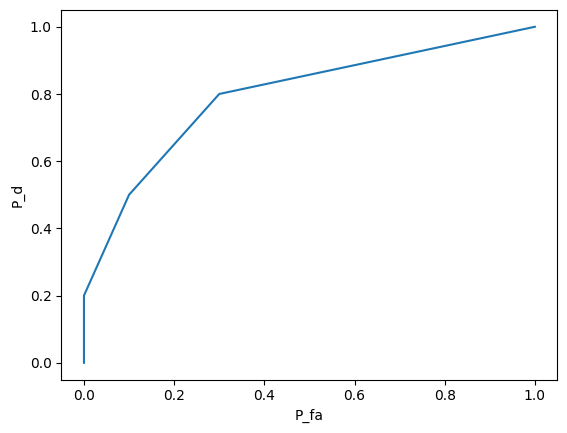

In [169]:
DATA = pandas.read_csv("knn3DecisionStatistics.csv", header=None)

def plotROC(pd,pfa,title=""):
    fig,ax = plt.subplots()
    ax.plot(pfa,pd)
    ax.set_xlabel("P_fa")
    ax.set_ylabel("P_d")
    ax.set_title(title)
    plt.show()


def getPD_PFA(data, k=3):
    pfa = []
    pd = []
    lambdas = [round(i/3, 5) for i in range(k+1)]
    eps = 1e-6
    h0s = data[data[0]==0]
    h1s = data[data[0]==1]
    for l in lambdas:
        pd.append(h1s[h1s[1]>=l].shape[0]/h0s.shape[0])
        pfa.append(h0s[h0s[1]>=l].shape[0]/h1s.shape[0])
    pd.append(0)
    pfa.append(0)
    return pd,pfa  

pd,pfa = getPD_PFA(DATA)
plotROC(pd,pfa)

## 1)

$\lambda = 0$: decide H0

$\lambda = \frac{1}{3}$: decide H1 with probability 0.7


$\lambda > \frac{1}{3}$: decide H1





## 2)

In [264]:

def probablisticDecisionSim(data, sims):
    actualNumH1 = data[(data[0] == 1)].shape[0]
    actualNumH0 = data[(data[0] == 0)].shape[0]

    # tune
    pickH1 = data[data[1] > round(1/3, 5)]
    probablistic_threshold = data[(data[1] == round(1/3, 5))]
    prob=0.7


    # simulation
    pds = []
    pfas = []
    for _ in range(sims):
        sample = np.random.choice([False, True], probablistic_threshold.shape[0], replace=True, p=[1-prob, prob])
        h1s = probablistic_threshold[sample]

        detects = pickH1[pickH1[0] == 1].shape[0] + h1s[h1s[0] == 1].shape[0]
        falseAlarms = pickH1[pickH1[0] == 0].shape[0] + h1s[h1s[0] == 0].shape[0]
        pds.append(detects/actualNumH1)
        pfas.append(falseAlarms/actualNumH0)
        
    return pds,pfas

# original ROC
pd,pfa = getPD_PFA(DATA)

# simulated probabilistic decision rlue
simulations = 100
pd_hat, pfa_hat = probablisticDecisionSim(DATA,simulations)

# kernel density estimation
from sklearn.neighbors import KernelDensity
pd_hat = np.array(pd_hat).reshape(-1,1)
pfa_hat = np.array(pfa_hat).reshape(-1,1)

pd_pdf = KernelDensity().fit(pd_hat)
pfa_pdf = KernelDensity().fit(pfa_hat)

pd_log_dens = pd_pdf.score_samples(pd_hat)
pfa_log_dens = pfa_pdf.score_samples(pfa_hat)
pd_dens = np.exp(pd_log_dens)
pfa_dens = np.exp(pfa_log_dens)

expected_pd = (np.sum(pd_hat * pd_dens) / np.sum(pd_dens))/100
expected_pfa = (np.sum(pfa_hat * pfa_dens) / np.sum(pfa_dens))/100

print(f"expected_pd: {round(expected_pd,3)}")
print(f"expected_pfa: {round(expected_pfa, 3)}")

expected_pd: 0.707
expected_pfa: 0.239


## 3)

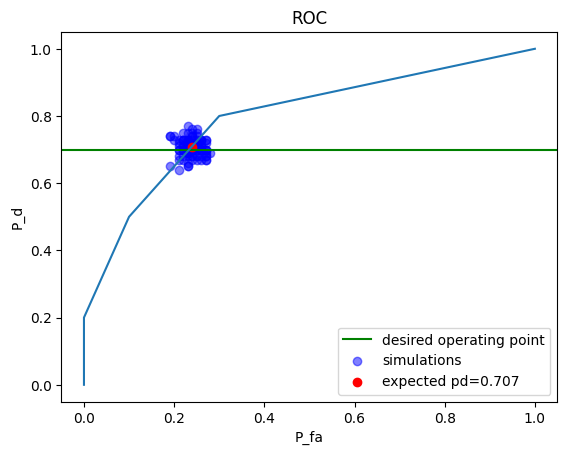

In [265]:
# plot
fig,ax = plt.subplots()
ax.axhline(0.7, label="desired operating point", color="green")
ax.plot(pfa,pd)
ax.scatter(pfa_hat, pd_hat, color="blue", alpha=0.5, label="simulations")
ax.scatter(expected_pfa, expected_pd, color="red", label=f"expected pd={round(expected_pd,3)}")
ax.set_xlabel("P_fa")
ax.set_ylabel("P_d")
ax.set_title("ROC")
ax.legend()
plt.show()

## 4)
The clustering of the individual operating points are distributed around the point on the ROC where PD=0.7

## 5)
The expected operating point is the intersection of the line between $\beta = \frac{1}{3}$ and $\beta = \frac{2}{3}$ and the line correlating with the desired operating point $PD=0.7$ 

# Curse of Dimensionality

## 7)

### a)

In [180]:
def montecarlo(pq,d, sims=10000):
    pennySamples = np.ndarray((pq,d))
    quarterSamples = np.ndarray((pq,d))
    separable = 0 

    for _ in range(sims):
        for j in range(pq):
            pennySamples[j,:] = np.random.choice([0,1],d,replace=True)
            quarterSamples[j,:] = np.random.choice([0,1],d,replace=True)
        
        same = np.where((pennySamples == quarterSamples).all(1))[0]
        if len(same) == 0:
            separable += 1
    probSeparable = separable/sims
    
    return probSeparable

    

In [181]:
D = 6
PQ = 6
MONTECARLOSIMS = 10000

probSeparable = montecarlo(PQ,D,MONTECARLOSIMS)
print("probability of class separability: ", probSeparable)


probability of class separability:  0.9148


### b)

It takes 160 flips for the probability of class separability to be less than 0.08 with D=6

In [178]:
probSeparable = 1
probs = []
pq = 100
while probSeparable > 0.08:
    pq += 10
    probSeparable = montecarlo(pq,6,MONTECARLOSIMS)
    probs.append(probSeparable)
    print(pq,probSeparable)
print(probs)


110 0.1801
120 0.1528
130 0.1299
140 0.1054
150 0.0885
160 0.08
[0.1801, 0.1528, 0.1299, 0.1054, 0.0885, 0.08]


### c)

The maximum D coin flips such that the probability of class separability is less than 0.08 is 1.

In [186]:
probSeparable = 0
probs_d = []
d = 0
while probSeparable < 0.08:
    d += 1
    probSeparable = montecarlo(6,d,MONTECARLOSIMS)
    print(d,probSeparable)
    probs_d.append(probSeparable)
print(probs_d)

1 0.0159
2 0.1811
[0.0159, 0.1811]


# Role of Data in Machine Learning

## 9)

### a)
I asked "what do you think about AI replacing human judgement vs AI augmenting human judgement"

ChatGPT 3.5 said:

```
The debate between AI replacing human judgment versus augmenting it is a nuanced one with various perspectives and considerations. Here's a breakdown of both sides:

**AI Replacing Human Judgment:**

1. **Efficiency**: AI can process vast amounts of data much faster than humans, potentially leading to quicker and more accurate decisions in certain contexts.
  
2. **Consistency**: AI algorithms can apply the same criteria consistently without being influenced by emotions, biases, or fatigue, which can lead to more uniform decision-making.

3. **Specialized Knowledge**: In some domains, AI systems can accumulate and process knowledge beyond human capacity, leading to decisions that are more informed and precise.

4. **Cost-Effectiveness**: Once developed, AI systems can operate 24/7 without breaks, which can reduce costs associated with human labor.

**Concerns with AI Replacing Human Judgment:**

1. **Ethical Concerns**: AI might lack the moral compass, empathy, and contextual understanding that humans bring to decision-making processes, leading to ethically questionable outcomes.

2. **Unintended Consequences**: AI may make decisions based on patterns in data that humans are not aware of, potentially leading to unexpected or undesired consequences.

3. **Accountability**: When AI makes decisions, it can be challenging to assign accountability, especially in cases of errors or biased outcomes.

**AI Augmenting Human Judgment:**

1. **Enhanced Decision-Making**: AI can provide additional insights and analysis to humans, helping them make more informed decisions by synthesizing large volumes of data and patterns.

2. **Human Oversight**: By augmenting human judgment, AI systems can serve as tools that humans use to make decisions, allowing for oversight and intervention when necessary.

3. **Personalization**: AI systems can adapt to individual preferences and needs, providing tailored recommendations or assistance to users.

4. **Learning Opportunities**: Humans can learn from the outputs and recommendations of AI systems, improving their own decision-making abilities over time.

**Concerns with AI Augmenting Human Judgment:**

1. **Overreliance**: There's a risk that humans may become overly reliant on AI recommendations, potentially diminishing their critical thinking and decision-making skills.

2. **Bias Amplification**: If the AI algorithms are trained on biased data or flawed assumptions, they can reinforce existing biases rather than mitigating them.

3. **Privacy**: Integrating AI into decision-making processes may raise concerns about privacy and data security, particularly if sensitive information is involved.

Ultimately, the optimal approach likely lies in finding a balance between AI replacing and augmenting human judgment, leveraging the strengths of both humans and machines to achieve the best outcomes while mitigating potential risks and concerns.
```

When I followed up with "which of the two is more important", ChatGPT 3.5 responded with:

```
Determining whether AI should primarily replace or augment human judgment depends on the specific context, the goals of the decision-making process, and the values of the stakeholders involved. Both approaches have their merits and potential drawbacks, so it's not necessarily a matter of one being inherently more important than the other. Instead, it's about striking the right balance based on the particular circumstances. 

For instance:

- In situations where speed and efficiency are paramount, such as high-frequency trading or certain medical diagnoses, AI systems may be better suited to replace human judgment due to their ability to process vast amounts of data quickly and consistently.

- On the other hand, in contexts where ethical considerations, creativity, and emotional intelligence are crucial, such as legal decision-making or artistic endeavors, augmenting human judgment with AI tools can enhance decision-making by providing additional insights and analysis without removing human oversight and accountability.

Therefore, the key is to carefully evaluate each scenario and determine whether AI should replace, augment, or collaborate with human judgment to achieve the desired outcomes effectively while minimizing potential risks and ethical concerns.
```

### b)

I think ChatGPT gives a thoughtful answer by responding with an "it depends" kind of answer. It highlights that while AI is faster, more consistent, more knowledgeable, and cheaper than humans, it can be ethically questionable due to unexpected bias in the training data, AI not having any moral values, and a lack of the ability to attribute accountability for when errors happen. For the most part, I've heard about all of these pros and cons of using AI for decision making. In my opinion, AI is best used to augment decision making, which is why I was more interested in what ChatGPT's thoughts about augmenting human judgement.

ChatGPT said AI augmenting human judgement had the benefit of being more informed at the cost of humans being overreliant of AI, biases being reinforced, and privacy concerns. I never really considered how humans being overreliant on AI could be a problem because I think that's an issue that is already pervasive in modern society. Personally, I don't remember many phone numbers, equations, or passwords since technology remembers them for me. Maybe I'm too far gone for me to think that overreliance on AI decision making is a bad thing. I'm also not sure if privacy is a problem since in my eyes, it's only an issue if the training data that's used is leaked to the public. 

In response to whether AI augmentation or AI replacing human judgement is more important, I liked how ChatGPT mentions how the context of the situation is important. I agree that situations that require fast decisions should replace human judgement, but I don't agree with the example used. It's been shown many times that there is terrible bias in medical AI tools especially against underrepresented groups like African Americans. I think for trivial things like a website's helper bot to assist people in navigating a website would've been a better example. 

I don't really think that ChatGPT's responses were superficial since it gives an analytical response that appeals to both sides of the argument. I also don't think I noticed any contraditions in what ChatGPT said.


# Mini Project Checkin

In [96]:
import warnings
warnings.filterwarnings("ignore")

import mp1
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


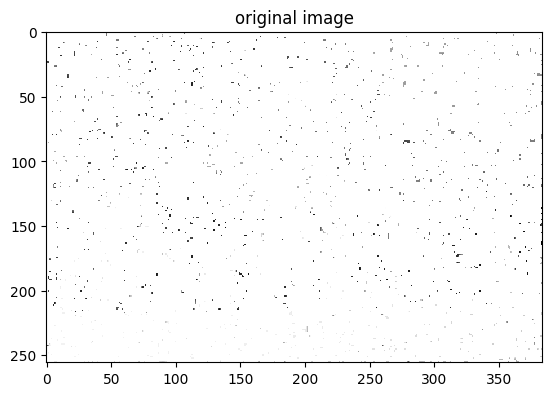

In [72]:
img = np.loadtxt('field_test_image.txt',delimiter=',')
fig,ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_title("original image")
plt.show()


In [92]:
nonnan = img[~np.isnan(img)]
approxS = 64 * nonnan.shape[0] // (img.shape[0] * img.shape[1])
print(approxS)
approxM = approxS//6
print(approxM)
reconstructed_img = mp1.reconstruct_img(img, approxM)

22
3


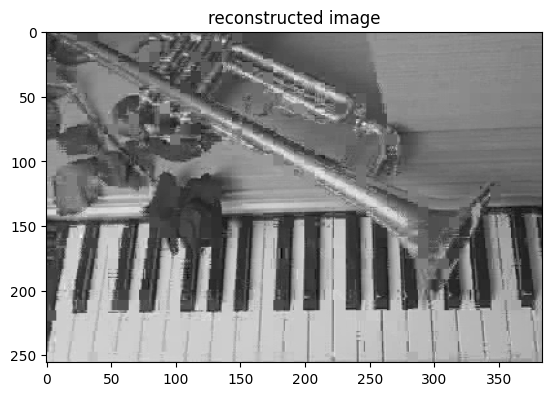

In [98]:
fig,ax = plt.subplots()
ax.imshow(reconstructed_img, cmap='gray')
ax.set_title("reconstructed image")
plt.show()

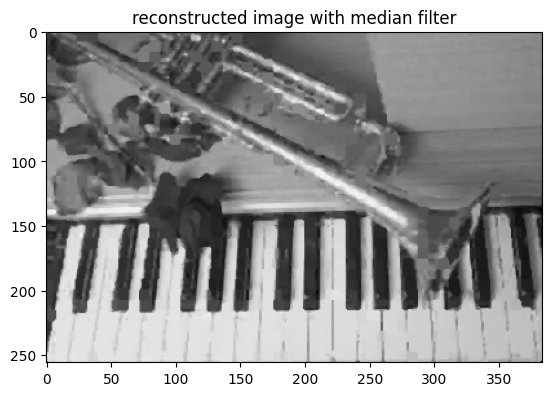

In [97]:
reconstructed_img_medfilt = signal.medfilt2d(reconstructed_img, kernel_size=3)
fig,ax = plt.subplots()
ax.imshow(reconstructed_img_medfilt, cmap='gray')
ax.set_title("reconstructed image with median filter")
plt.show()